In [1]:
# import packages 
import numpy as np 

import h5py
import os
import re

from scipy import stats
from scipy import signal
import scipy.optimize

import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import matplotlib as mpl
import matplotlib.cm as mpl_cm
import matplotlib.colors as mpl_colors
import matplotlib.offsetbox as mpl_offsetbox
import matplotlib.gridspec as mpl_gridspec

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "Arial"
# mpl.rcParams.update({'font.size': 6.5})
mpl.rcParams.update({'font.size': 8})

print(mpl.rcParams['font.family'])
print(mpl.rcParams['font.sans-serif'])
print(mpl.rcParams['font.size'])

['Arial']
['Arial']
8.0


In [2]:
# Save progress 
HISTORY_FILEPATH = r"\\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\ExampleTarcePlotVer03 - Copy.py"
LAST_SAVE_TIME = 0
SAVE_INTERVAL_S = 15*60
def SAVE_PROGRESS(dst_file_path):
    global LAST_SAVE_TIME, SAVE_INTERVAL_S
    import time
    cur_time = time.time()
    if (cur_time - LAST_SAVE_TIME) < SAVE_INTERVAL_S:
        print(f"Time since last sync = {(cur_time - LAST_SAVE_TIME):0.2f} s" )
        return
    LAST_SAVE_TIME = cur_time
    try:
        from datetime import datetime
        dst_dir_path, dst_file_name = os.path.split(dst_file_path)
        dst_file_name = os.path.splitext(dst_file_name)[0] + "_" + datetime.today().strftime('%Y-%m-%d') + os.path.splitext(dst_file_name)[1]
        dst_file_path = os.path.join(dst_dir_path, dst_file_name)
        if not os.path.isdir(dst_dir_path):
            os.makedirs(dst_dir_path)
        if os.path.exists(dst_file_path):
            os.remove(dst_file_path)
        %history -t -g -f $dst_file_path
        dst_notebook_path = os.path.splitext(dst_file_path)[0] + ".ipynb"
        %notebook $dst_notebook_path
        print("Progress saved to: " + dst_file_path)
    except Exception as e:
        print("Progress sync failed, error: ",e)

In [3]:
# count spike in time stamp
def cnt_spike_in_time_stamp(spike_event, stim_tstamp):
    
    nof_traces = spike_event.shape[0]
    trace_len = spike_event.shape[1]
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    spike_cnts = np.zeros((nof_orint, nof_steps, nof_traces), dtype = np.float)
        
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_start = max(0, tstamp_start)
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            tstamp_end = min(trace_len, tstamp_end)
            if tstamp_start >= tstamp_end:
                continue
            tstamp_spike_event_mask = spike_event[:, tstamp_start:tstamp_end] > 0
            nof_spikes = np.sum(tstamp_spike_event_mask.astype(int), axis = -1)
            spike_cnts[i_orint, i_step, :] = nof_spikes
            
    return spike_cnts

def calculate_spike_rate_s(spike_cnts, stim_tstamp_s):
    nof_orint = spike_cnts.shape[0]
    nof_steps = spike_cnts.shape[1]
    nof_traces = spike_cnts.shape[2]
    
    spike_rate = np.zeros((nof_orint, nof_steps, nof_traces), dtype = np.float)
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            stamp_t_s = stim_tstamp_s[i_orint, i_step, :]
            duration_s = stamp_t_s[-1] - stamp_t_s[0]
            if duration_s == 0:
                continue
            spike_rate[i_orint, i_step, :] = spike_cnts[i_orint, i_step, :].astype(np.float) / duration_s
            
    return spike_rate

def bw_lp_filtering(order, cutoff, fs, src_traces):
    b, a = signal.butter(order, cutoff, "lp", fs = fs, output = "ba")
    dst_traces = signal.filtfilt(b, a, src_traces, method="gust", axis = -1)
    return dst_traces
    
SAVE_PROGRESS(HISTORY_FILEPATH)  

Progress sync failed, error:  unrecognized arguments: - Copy_2024-05-22.ipynb


In [4]:
# basic plot functions
def raster_plot(spike_events, event_color = "k"):
    plt_xs = np.arange(spike_events.shape[1])
    event_xs = []
    for i_trail in range(spike_events.shape[0]):
        event_xs.append(plt_xs[spike_events[i_trail,:] > 0])
    plt.eventplot(event_xs, color = event_color,
                 lineoffsets = 1,
                 linelengths = 1,
                 linewidths = 0.5)

def stim_time_stamp_axvspan(stim_tstamp, facecolor_strs = ['b', 'r', 'b']):
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            if tstamp_start >= tstamp_end:
                continue
            plt.axvspan(tstamp_start, tstamp_end, facecolor = facecolor_strs[i_step], alpha=0.1)

def stim_time_stamp_axvline(stim_tstamp, facecolor_strs = ['b', 'r', 'b']):
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            if tstamp_start >= tstamp_end:
                continue
            plt.axvline(tstamp_start, color = facecolor_strs[i_step])
            plt.axvline(tstamp_end, color = facecolor_strs[i_step])
    
SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 1.30 s


In [5]:
# display configuration

my_monitor_dpi_px = 96
illustrator_mointor_dpi_px = 72
letter_paper_size_inch = np.array((8.5, 11))

full_page_figure_illustrator_size_pxls = np.array([521, 655])
full_page_paper_illustrator_size_pxls = np.array([620, 801])
paper_to_illustrator_ratio = full_page_figure_illustrator_size_pxls/full_page_paper_illustrator_size_pxls

plot_panel_label_font_size = 8
plot_axis_label_font_size = 7
plot_numeric_label_font_size = 6.5

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 2.77 s


In [6]:
# acqusition configuration
time_per_frame_ms = 2.6 
ms_to_s = 1e-3
s_to_ms = 1e3

bw_order = 12
bw_cutoff = 50
fs = 1 * s_to_ms / time_per_frame_ms

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 6.26 s


In [7]:
src_hdf5_file_path = r"J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\stats_analysis_data.hdf5"

dst_dir_path = os.path.split(src_hdf5_file_path)[0]
dst_plot_subdir_name = "tmp"

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 40.08 s


In [8]:
# load source data 

nof_rois = None
nof_trials = None
nof_frames = None
nof_orient = None

stim_tstamp_s = None
stim_tstamp = None

t_test_pass_mask = None
diff_t_test_pass_mask = None
gather_t_test_pass_mask = None
anova_test_pass_mask = None
diff_anova_test_pass_mask = None

roi_spike_events = None
roi_subthd_dFFs = None
roi_spike_rates = None
roi_vec_sum_ang = None
snrs = None
dFF_s = None
F0_s = None
t_s = None
raw_dFFs = None

with h5py.File(src_hdf5_file_path, "r") as hdf5_file:
    nof_rois = hdf5_file["nof_roi"][()]
    nof_frames = hdf5_file["nof_frames"][()]
    nof_orients = hdf5_file["nof_orient"][()]
    nof_trials = hdf5_file["nof_files"][()]
    
    stim_tstamp_s = hdf5_file["stim_tstamp_s"][()]
    stim_tstamp = hdf5_file["stim_tstamp"][()]

    dFF_s = hdf5_file["dFFs"][()]
    F0_s = hdf5_file["F0"][()]
    t_s = hdf5_file["t"][()]
    snrs = hdf5_file["snrs"][()]
    raw_dFFs = hdf5_file["raw_dFFs"][()]
    
    nof_tstamps = stim_tstamp.shape[1]

    t_test_pass_mask = np.full((nof_rois,), False)
    diff_t_test_pass_mask = np.full((nof_rois,), False)
    gather_t_test_pass_mask = np.full((nof_rois,), False)
    anova_test_pass_mask = np.full((nof_rois,), False)
    diff_anova_test_pass_mask = np.full((nof_rois,), False)

    roi_spike_events = np.zeros((nof_rois, nof_trials, nof_frames))
    roi_subthd_dFFs = np.zeros((nof_rois, nof_trials, nof_frames))
    roi_spike_rates = np.zeros((nof_rois, nof_orients, nof_tstamps, nof_trials))
    roi_vec_sum_ang = np.zeros((nof_rois,))
    
    for i_roi in range(nof_rois):
        cur_roi_str = f"roi{i_roi}"
        roi_spike_events[i_roi, :, :] = hdf5_file[os.path.join(cur_roi_str, "cur_spike_event")][()]
        roi_subthd_dFFs[i_roi, :, :] = hdf5_file[os.path.join(cur_roi_str, "cur_subthreshold_dFF")][()]
        
        t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "t_test_pass")][()]
        diff_t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "diff_t_test_pass")][()]
        gather_t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "gather_t_test_pass")][()]
        anova_test_pass_mask[i_roi] = hdf5_file[os.path.join(cur_roi_str, "anova_test_pass")][()]
        diff_anova_test_pass_mask[i_roi] = hdf5_file[os.path.join(cur_roi_str, "diff_anova_test_pass")][()]
        roi_spike_rates[i_roi,:,:,:] = hdf5_file[os.path.join(cur_roi_str, "cur_spike_rate")][()]
        roi_vec_sum_ang[i_roi] = hdf5_file[os.path.join(cur_roi_str, "vec_sum_complex.ang")][()]

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 52.76 s


In [9]:
print(np.sum(t_test_pass_mask))
print(np.sum(diff_t_test_pass_mask))
print(np.sum(np.logical_and(t_test_pass_mask, anova_test_pass_mask)))
print(np.sum(np.logical_and(diff_t_test_pass_mask, anova_test_pass_mask)))
print(np.sum(np.logical_and(t_test_pass_mask, diff_anova_test_pass_mask)))
print(np.sum(np.logical_and(diff_t_test_pass_mask, diff_anova_test_pass_mask)))

SAVE_PROGRESS(HISTORY_FILEPATH)

77
100
63
76
24
26
Time since last sync = 52.77 s


In [10]:
print(snrs.shape)

snr_threshold = 3.5

print(np.sum(snrs > snr_threshold))
print(np.where(snrs > snr_threshold))

print(np.stack(np.where(snrs > snr_threshold), axis = -1))

SAVE_PROGRESS(HISTORY_FILEPATH)

(202, 37)
81
(array([  6,   6,   8,  16,  24,  30,  30,  30,  30,  30,  39,  40,  41,
        43,  44,  49,  49,  51,  51,  51,  51,  53,  53,  58,  76,  77,
        77,  77,  77,  77,  77,  77,  77,  77,  77,  77,  79,  82,  83,
        83,  84,  84,  85,  85,  86,  86,  88,  88,  88,  92,  92,  96,
       112, 113, 113, 113, 119, 124, 124, 126, 126, 126, 128, 128, 128,
       128, 130, 130, 130, 132, 139, 139, 140, 147, 147, 149, 158, 171,
       177, 188, 201], dtype=int64), array([ 1, 30, 18,  0, 31,  0,  1,  7, 17, 30, 11, 25, 25,  1, 15,  9, 31,
        6, 14, 31, 36, 25, 34,  6, 12,  0,  1,  2,  5,  6, 10, 20, 21, 27,
       32, 34, 14, 19,  3, 36, 16, 23,  6, 36,  5, 27,  2, 28, 29, 27, 34,
        8, 28,  3,  8, 12,  8,  4, 13, 11, 19, 28,  0,  8, 21, 29,  2,  5,
       18,  0, 17, 36, 28, 21, 33,  4,  9,  7, 26,  6, 33], dtype=int64))
[[  6   1]
 [  6  30]
 [  8  18]
 [ 16   0]
 [ 24  31]
 [ 30   0]
 [ 30   1]
 [ 30   7]
 [ 30  17]
 [ 30  30]
 [ 39  11]
 [ 40  25]
 [ 41  25]


In [13]:
dst_plot_subdir_path = os.path.join(dst_dir_path, dst_plot_subdir_name)

if not os.path.isdir(dst_plot_subdir_path):
    os.makedirs(dst_plot_subdir_path)

print(dst_plot_subdir_path)

SAVE_PROGRESS(HISTORY_FILEPATH)

J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\tmp
Time since last sync = 123.19 s


IndexError: index 16 is out of bounds for axis 1 with size 16

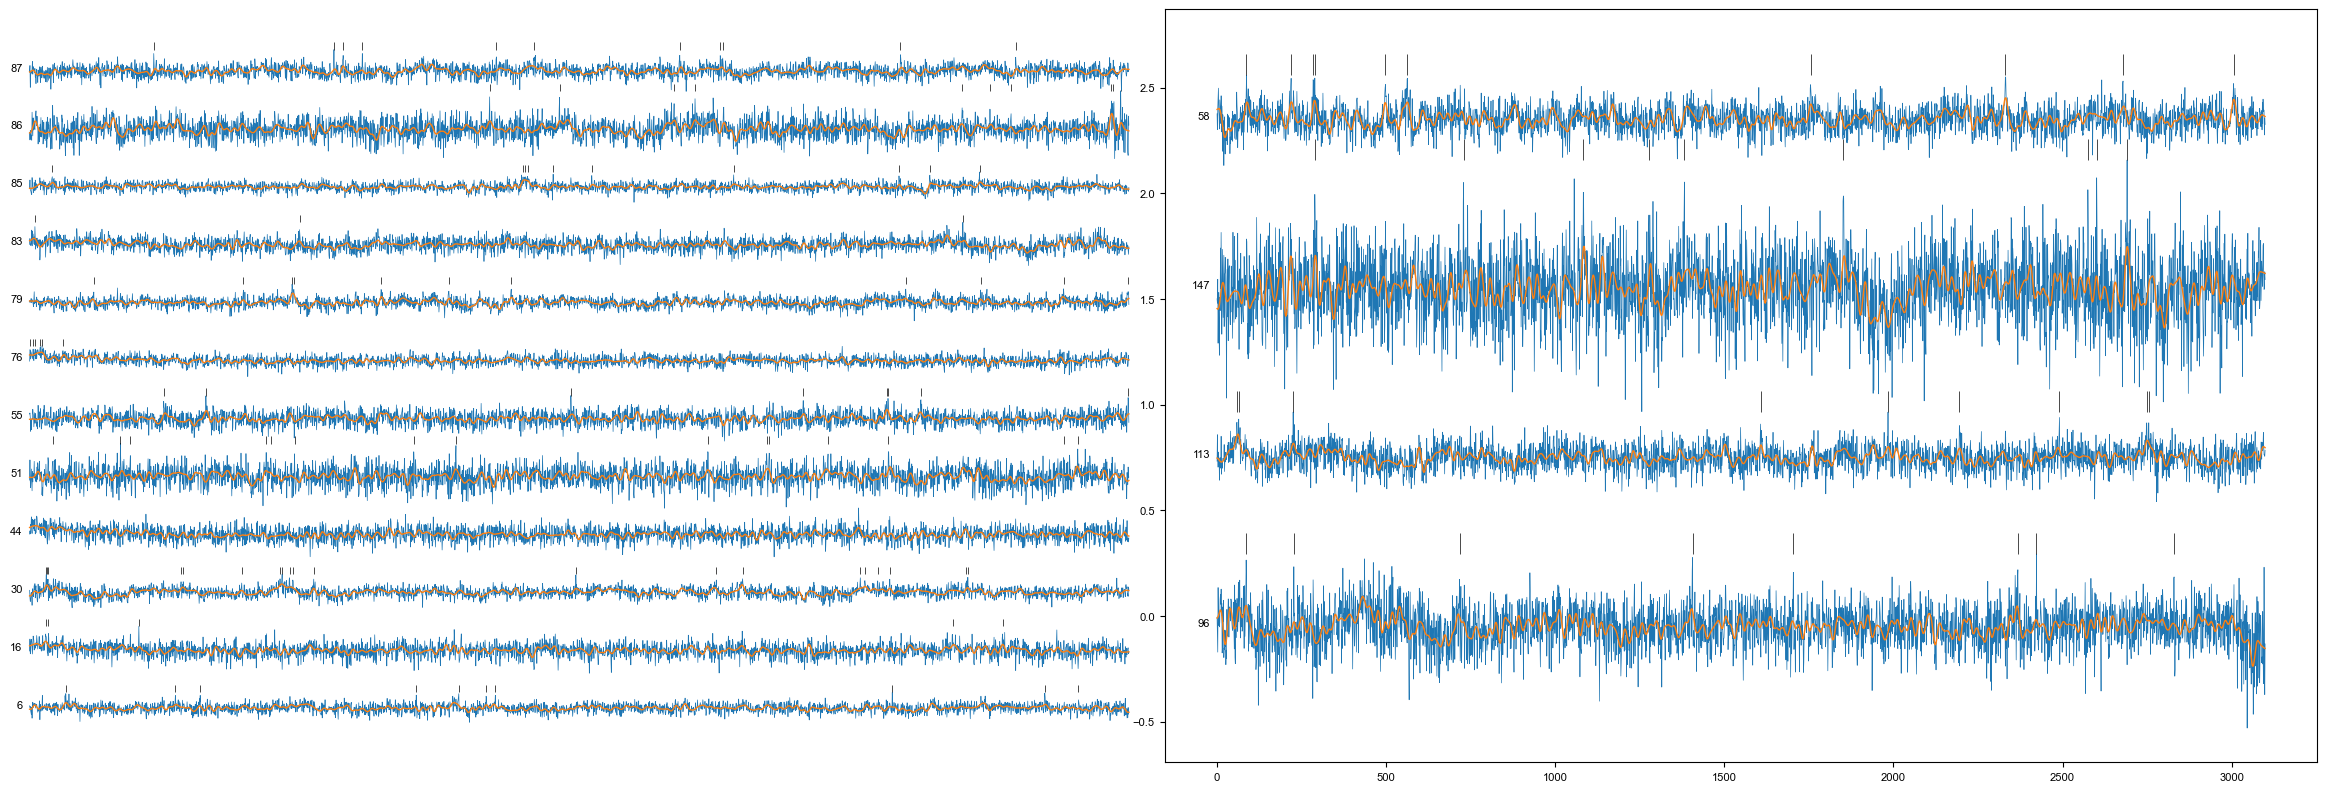

In [13]:
plot_roi_trial_pair = np.array([
    [6, 1],
    [16, 0],
    # [17, 11],
    [30, 0],
    [44, 8],
    [51, 6],
    [55, 13],
    # [66, 2],
    [76, 6],
    # [77, 10],
    [79, 4],
    [83, 5],
    [85, 6],
    [86, 11],
    [87, 12],
    [96, 0],
    [113, 0],
    # [130, 5],
    [147, 4],
    [58, 12],
    [8, 16],
    # [21, 5],
    [46, 13],
    [108, 10],
    [124, 13],
    [126, 7],
    [128, 8],
    [139, 17],
    # [141, 17],
    ],dtype = int)

plot_zoom_roi_trial_pair = np.array([
    [17, 11],
    [77, 10],
    [66, 2],
    [130, 5],
    # [83, 5],
],dtype = int)

plot_roi_idxs = plot_roi_trial_pair[:,0]
plot_trial_idxs = plot_roi_trial_pair[:,1]

plot_zoom_roi_idxs = plot_zoom_roi_trial_pair[:,0]
plot_zoom_trial_idxs = plot_zoom_roi_trial_pair[:,1]

input_dFFs = dFF_s
# input_dFFs = raw_dFFs
input_spike_events = roi_spike_events
input_subthd_dFFs = roi_subthd_dFFs

nof_rois, nof_trials, trace_len = input_dFFs.shape

nof_plot_rois = len(plot_roi_idxs)

plot_trace_offset = 0.8
plot_spike_y_offset = 0.05
plot_roi_text_offset = np.array([-20, 0])

# plot_font_size = 6.5
plot_font_size = 8

plot_dt_s = time_per_frame_ms * ms_to_s
plot_ts = np.linspace(0,8,9)
plot_x_ticks = (plot_ts/plot_dt_s).astype(int)
plot_x_labels = plot_ts

plot_nof_subplots = 2
plot_nof_trace_per_subplot = int(np.ceil(nof_plot_rois/plot_nof_subplots))
nof_zoom_rois = plot_zoom_roi_trial_pair.shape[0]

plot_ylims = [-plot_trace_offset, plot_trace_offset * plot_nof_trace_per_subplot]
plot_zoom_ylims = [-plot_trace_offset/2, plot_trace_offset * nof_zoom_rois]
plot_xmargins = np.array([-50, 100])
plot_xlims = np.array([0, input_dFFs.shape[-1]]) + plot_xmargins

plot_time_scale_bar_len_s = 1
plot_time_scale_bar_size = plot_time_scale_bar_len_s/plot_dt_s
plot_time_scale_bar_y = plot_ylims[-1] - plot_trace_offset*0.8
plot_time_scale_bar_right_offset = trace_len - trace_len/3
plot_time_scale_bar_ys = np.array([plot_time_scale_bar_y, plot_time_scale_bar_y])
plot_time_scale_bar_xs = np.array([plot_time_scale_bar_right_offset - plot_time_scale_bar_size,
                                   plot_time_scale_bar_right_offset])
plot_time_scale_bar_linewidth = 2

plot_dFF_scale_bar_len = 0.2
plot_dFF_scale_bar_size = plot_dFF_scale_bar_len
plot_dFF_scale_bar_y_top_offset = plot_time_scale_bar_y
plot_dFF_scale_bar_ys = np.array([plot_dFF_scale_bar_y_top_offset, 
                                  plot_dFF_scale_bar_y_top_offset - plot_dFF_scale_bar_size])
plot_dFF_scale_bar_xs = np.array([plot_time_scale_bar_right_offset,
                                   plot_time_scale_bar_right_offset])
plot_dFF_scale_bar_linewidth = 2

plot_zoom_time_scale_bar_len_s = 0.5
plot_zoom_time_scale_bar_size = plot_zoom_time_scale_bar_len_s/plot_dt_s
plot_zoom_time_scale_bar_y = plot_zoom_ylims[-1] - plot_trace_offset*0.25
plot_zoom_time_scale_bar_right_offset = trace_len - trace_len/20
plot_zoom_time_scale_bar_ys = np.array([plot_zoom_time_scale_bar_y, plot_zoom_time_scale_bar_y])
plot_zoom_time_scale_bar_xs = np.array([plot_zoom_time_scale_bar_right_offset - plot_zoom_time_scale_bar_size,
                                        plot_zoom_time_scale_bar_right_offset])
plot_zoom_time_scale_bar_linewidth = 2

plot_zoom_dFF_scale_bar_len = 0.1
plot_zoom_dFF_scale_bar_size = plot_zoom_dFF_scale_bar_len
plot_zoom_dFF_scale_bar_y_top_offset = plot_zoom_time_scale_bar_y
plot_zoom_dFF_scale_bar_ys = np.array([plot_zoom_dFF_scale_bar_y_top_offset, 
                                      plot_zoom_dFF_scale_bar_y_top_offset - plot_zoom_dFF_scale_bar_size])
plot_zoom_dFF_scale_bar_xs = np.array([plot_zoom_time_scale_bar_right_offset,
                                      plot_zoom_time_scale_bar_right_offset])
plot_zoom_dFF_scale_bar_linewidth = 2


fig_width = letter_paper_size_inch[0] * (7/8) * 4
fig_height = letter_paper_size_inch[1] * (1/3) * 4

dst_figure_name = r"example_traces_ver01_new"

dst_png_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".png")
dst_eps_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".eps")
dst_pdf_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pdf")
dst_pkl_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pickle")
dst_hdf5_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".hdf5")
dst_notebook_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".ipynb")

plot_xs = np.arange(trace_len)

fig = plt.figure(figsize = (fig_width, fig_height))

fig_gs = mpl_gridspec.GridSpec(2, 1, 
                                wspace = 0,
                                hspace = 0,
                                height_ratios = [2,4], 
                                figure = fig)

gs = mpl_gridspec.GridSpecFromSubplotSpec(1, plot_nof_subplots, 
                                                        wspace = 0,
                                                        hspace = 0,
                                                        subplot_spec=fig_gs[1,0])

for i_subplot in range(plot_nof_subplots):
    # plt.subplot(1, plot_nof_subplots, i_subplot + 1)
    plt.subplot(gs[0,i_subplot])
    plot_ax = plt.gca()
    for i_roi in range(i_subplot * plot_nof_trace_per_subplot, min((i_subplot+1)*plot_nof_trace_per_subplot, nof_plot_rois)):
        cur_roi_idx = plot_roi_idxs[i_roi]
        cur_trial_idx = plot_trial_idxs[i_roi]
        cur_trace_y_offset =  (i_roi - i_subplot * plot_nof_trace_per_subplot) * plot_trace_offset - plot_spike_y_offset
        cur_trace_ys = input_dFFs[cur_roi_idx, cur_trial_idx, :] + cur_trace_y_offset
        cur_subthd_trace_ys = input_subthd_dFFs[cur_roi_idx, cur_trial_idx, :] + cur_trace_y_offset
        cur_spike_mask = input_spike_events[cur_roi_idx, cur_trial_idx, :] > 0
        plt.plot(plot_xs, cur_trace_ys ,
                color = "#1f77b4",
                linewidth = 0.5,
                )
        plt.plot(plot_xs, cur_subthd_trace_ys ,
                color = "#ff7f0e",
                linewidth = 1,
                )
        plt.text(0 + plot_roi_text_offset[0], cur_trace_y_offset + plot_roi_text_offset[1], 
                 f"{cur_roi_idx}", 
                 color = "black", 
                 horizontalalignment = "right",
                 verticalalignment = "baseline",
                 fontsize = plot_font_size,
                 fontname = "Arial") 
        cur_event_y_offset =  (i_roi - i_subplot * plot_nof_trace_per_subplot + 1) * plot_trace_offset - plot_spike_y_offset
        plt.eventplot(plot_xs[cur_spike_mask],
                      lineoffsets = np.max(cur_trace_ys) + plot_spike_y_offset,
                      # lineoffsets = cur_event_y_offset,
                      colors = "black",
                      linelengths = 0.1,
                      linewidth = 0.5,
                     )
    if i_subplot == plot_nof_subplots - 1:
        plt.plot(plot_time_scale_bar_xs, plot_time_scale_bar_ys,
                linewidth = plot_time_scale_bar_linewidth,
                color = "black")
        plt.text(
                 x = plot_time_scale_bar_xs[0],
                 y = plot_time_scale_bar_ys[0] + 0.05,
                 s = f"{plot_time_scale_bar_len_s} s",
                 horizontalalignment='left',
                 color = "black",
                 fontsize = plot_font_size, 
                 fontname = "Arial"
                 # fontweight = "bold",
        )
        plt.plot(plot_dFF_scale_bar_xs, plot_dFF_scale_bar_ys,
                linewidth = plot_dFF_scale_bar_linewidth,
                color = "black")
        plt.text(
                 x = plot_dFF_scale_bar_xs[0] + 50,
                 y =  np.mean(plot_dFF_scale_bar_ys) - 0.5 * np.abs(plot_dFF_scale_bar_ys[1] - plot_dFF_scale_bar_ys[0]),
                 s = "$\mathrm{\Delta}$F/F = " + f"-{plot_dFF_scale_bar_len * 100}%",
                 horizontalalignment='left',
                 color = "black",
                 fontsize = plot_font_size, 
                 fontname = "Arial"
                 # fontweight = "bold",
        )

    plt.xlim(plot_xlims)
    plt.ylim(plot_ylims)
    
    plot_ax.tick_params(axis='both', which='major', 
                        labelsize=plot_font_size, pad = 2)
    plot_ax.tick_params(axis='both', which='minor', 
                        labelsize=plot_font_size)
    # plt.xticks(ticks = plot_x_ticks, labels = plot_x_labels)
    # plt.xlabel("Time (s)", 
    #            fontsize = plot_font_size, fontname = "arial", labelpad = 1)
    # plt.xlim(left = plot_x_ticks[0],
    #          right = plot_x_ticks[-1])
    plot_ax.axes.get_xaxis().set_ticks([])
    plot_ax.set_xticklabels([])
    plot_ax.axes.get_yaxis().set_ticks([])
    plot_ax.set_yticklabels([])
    plot_ax.spines['top'].set_visible(False)
    plot_ax.spines['bottom'].set_visible(False)
    plot_ax.spines['left'].set_visible(False)
    plot_ax.spines['right'].set_visible(False)


plot_ax = plt.subplot(fig_gs[0,0])
for i_roi in range(nof_zoom_rois):
    cur_roi_idx = plot_zoom_roi_idxs[i_roi]
    cur_trial_idx = plot_zoom_trial_idxs[i_roi]
    cur_trace_y_offset =  (i_roi) * plot_trace_offset - plot_spike_y_offset
    cur_trace_ys = input_dFFs[cur_roi_idx, cur_trial_idx, :] + cur_trace_y_offset
    cur_subthd_trace_ys = input_subthd_dFFs[cur_roi_idx, cur_trial_idx, :] + cur_trace_y_offset
    cur_spike_mask = input_spike_events[cur_roi_idx, cur_trial_idx, :] > 0
    plt.plot(plot_xs, cur_trace_ys ,
            color = "#1f77b4",
            linewidth = 1,
            )
    plt.plot(plot_xs, cur_subthd_trace_ys ,
            color = "#ff7f0e",
            linewidth = 2,
            )
    plt.text(0 + plot_roi_text_offset[0], cur_trace_y_offset + plot_roi_text_offset[1], 
            f"{cur_roi_idx}", 
            color = "black", 
            horizontalalignment = "right",
            verticalalignment = "baseline",
            fontsize = plot_font_size,
            fontname = "Arial") 
    cur_event_y_offset =  (i_roi - i_subplot * nof_zoom_rois + 1) * plot_trace_offset - plot_spike_y_offset
    plt.eventplot(plot_xs[cur_spike_mask],
                 lineoffsets = np.max(cur_trace_ys) + plot_spike_y_offset,
                  # lineoffsets = cur_event_y_offset,
                  colors = "black",
                  linelengths = 0.05,
                  linewidth = 1,
                 )
plt.xlim(plot_xlims)
plt.ylim(plot_zoom_ylims)
    
plot_ax.tick_params(axis='both', which='major', 
                    labelsize=plot_font_size, pad = 2)
plot_ax.tick_params(axis='both', which='minor', 
                    labelsize=plot_font_size)
plot_ax.axes.get_xaxis().set_ticks([])
plot_ax.set_xticklabels([])
plot_ax.axes.get_yaxis().set_ticks([])
plot_ax.set_yticklabels([])
plot_ax.spines['top'].set_visible(False)
plot_ax.spines['bottom'].set_visible(False)
plot_ax.spines['left'].set_visible(False)
plot_ax.spines['right'].set_visible(False)


plt.plot(plot_zoom_time_scale_bar_xs, plot_zoom_time_scale_bar_ys,
        linewidth = plot_zoom_time_scale_bar_linewidth,
        color = "black")
plt.text(
        x = plot_zoom_time_scale_bar_xs[0],
        y = plot_zoom_time_scale_bar_ys[0] + 0.05,
        s = f"{plot_zoom_time_scale_bar_len_s} s",
        horizontalalignment='left',
        color = "black",
        fontsize = plot_font_size, 
        fontname = "Arial"
        )
plt.plot(plot_zoom_dFF_scale_bar_xs, plot_zoom_dFF_scale_bar_ys,
        linewidth = plot_zoom_dFF_scale_bar_linewidth,
        color = "black")
plt.text(
        x = plot_zoom_dFF_scale_bar_xs[0] + 5,
        y =  np.mean(plot_zoom_dFF_scale_bar_ys) - 0.5 * np.abs(plot_zoom_dFF_scale_bar_ys[1] - plot_zoom_dFF_scale_bar_ys[0]),
        s = "$\mathrm{\Delta}$F/F = " + f"-{plot_zoom_dFF_scale_bar_len * 100}%",
        horizontalalignment='left',
        color = "black",
        fontsize = plot_font_size, 
        fontname = "Arial"
        )



fig.savefig("test.pdf", format = "pdf", bbox_inches = 'tight')

with open(dst_pkl_figure_path, "wb") as dst_pkl_file:
    pickle.dump(fig, dst_pkl_file)

print("pickle dump to: " + dst_pkl_figure_path)

with h5py.File(dst_hdf5_figure_path, "w") as hdf5_file:
    hdf5_file.create_dataset("plot_roi_trial_pair", data = plot_roi_trial_pair)
    hdf5_file.create_dataset("plot_zoom_roi_trial_pair", data = plot_zoom_roi_trial_pair)
    hdf5_file.create_dataset("input_dFFs", data = input_dFFs)
    hdf5_file.create_dataset("input_subthd_dFFs", data = input_subthd_dFFs)
    hdf5_file.create_dataset("input_spike_events", data = input_spike_events)
    hdf5_file.create_dataset("plot_trace_offset", data = plot_trace_offset)
    hdf5_file.create_dataset("plot_spike_y_offset", data = plot_spike_y_offset)
    hdf5_file.create_dataset("plot_dt_s", data = plot_dt_s)
    hdf5_file.create_dataset("plot_ts", data = plot_ts)
    hdf5_file.create_dataset("plot_nof_subplots", data = plot_nof_subplots)
    hdf5_file.create_dataset("plot_xmargins", data = plot_xmargins)
    hdf5_file.create_dataset("plot_xlims", data = plot_xlims)
    hdf5_file.create_dataset("plot_ylims", data = plot_ylims)
    hdf5_file.create_dataset("plot_zoom_ylims", data = plot_zoom_ylims)
    hdf5_file.create_dataset("plot_roi_text_offset", data = plot_roi_text_offset)

print("data saved to: " + dst_hdf5_figure_path)

%notebook $dst_notebook_path

fig.savefig(dst_png_figure_path, format = "png", bbox_inches = 'tight', dpi = 600)
fig.savefig(dst_eps_figure_path, format = "eps", bbox_inches = 'tight')
fig.savefig(dst_pdf_figure_path, format = "pdf", bbox_inches = 'tight')

print("plot saved to: " + dst_pdf_figure_path)

plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

meta NOT subset; don't know how to subset; dropped


pickle dump to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\tmp\example_traces.pickle
data saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\tmp\example_traces.hdf5


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


plot saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\tmp\example_traces.pdf


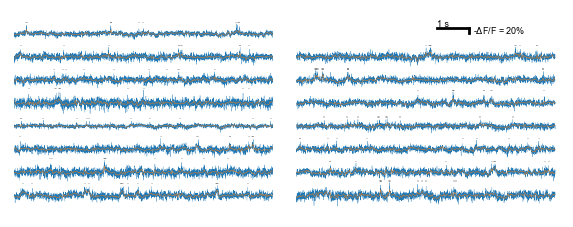

Time since last sync = 187.99 s


In [26]:
# plot_roi_trial_pair = np.array([
#     [5, 7],
#     [10, 4],
#     [11, 2],
#     # [12, 7],
#     [18, 7],
#     # [25, 4],
#     [26, 0],
#     [27, 14],
#     # [28, 4],
#     [32, 11],
#     [33, 7],
#     # [41, 4],
#     [42, 2],
#     [56, 8],
#     [58, 2],
#     [59, 9],
#     [61, 7],
#     [66, 2],
#     # [71, 10],
#     [80, 7],
#     [85, 4],
#     # [94, 7],
#     [97, 5],
#     [98, 12],
#     [100, 5],
#     [101,2],
#     [103, 9],
#     [108, 2],
#     [146, 13],
#     [150, 7],
#     [154, 13],
#     ],dtype = int)


plot_roi_trial_pair = np.array([
    [6, 1],
    [8, 16],
    [16, 0],
    # [21, 5],
    # [30, 0],
    [51, 6],
    [55, 13],
    [58, 12],
    [66, 2],
    [77, 10],
    # [79, 4],
    [85, 6],
    [86, 11],
    [87, 12],
    [96, 0],
    [113, 0],
    [126, 7],
    [130, 10],
    # [141, 17],
    ],dtype = int)


plot_roi_idxs = plot_roi_trial_pair[:,0]
plot_trial_idxs = plot_roi_trial_pair[:,1]

input_dFFs = dFF_s
# input_dFFs = raw_dFFs
input_spike_events = roi_spike_events
input_subthd_dFFs = roi_subthd_dFFs

nof_rois, nof_trials, trace_len = input_dFFs.shape

nof_plot_rois = len(plot_roi_idxs)

# plot_trace_offset = 0.6
plot_trace_offset = 0.8
# plot_spike_y_offset = 0.05
plot_spike_y_offset = 0.05
plot_roi_text_offset = np.array([-20, 0])

plot_dt_s = time_per_frame_ms * ms_to_s
plot_ts = np.linspace(0,8,9)
plot_x_ticks = (plot_ts/plot_dt_s).astype(int)
plot_x_labels = plot_ts

plot_nof_subplots = 2
plot_nof_trace_per_subplot = int(np.ceil(nof_plot_rois/plot_nof_subplots))

plot_ylims = [-plot_trace_offset, plot_trace_offset * plot_nof_trace_per_subplot]
plot_xmargins = np.array([-50, 100])
plot_xlims = np.array([0, input_dFFs.shape[-1]]) + plot_xmargins

plot_time_scale_bar_len_s = 1
plot_time_scale_bar_size = plot_time_scale_bar_len_s/plot_dt_s
plot_time_scale_bar_y = plot_ylims[-1] - plot_trace_offset*0.8
plot_time_scale_bar_right_offset = trace_len - trace_len/3
plot_time_scale_bar_ys = np.array([plot_time_scale_bar_y, plot_time_scale_bar_y])
plot_time_scale_bar_xs = np.array([plot_time_scale_bar_right_offset - plot_time_scale_bar_size,
                                   plot_time_scale_bar_right_offset])
plot_time_scale_bar_linewidth = 2

plot_dFF_scale_bar_len = 0.2
plot_dFF_scale_bar_size = plot_dFF_scale_bar_len
plot_dFF_scale_bar_y_top_offset = plot_time_scale_bar_y
plot_dFF_scale_bar_ys = np.array([plot_dFF_scale_bar_y_top_offset, 
                                  plot_dFF_scale_bar_y_top_offset - plot_dFF_scale_bar_size])
plot_dFF_scale_bar_xs = np.array([plot_time_scale_bar_right_offset,
                                   plot_time_scale_bar_right_offset])
plot_dFF_scale_bar_linewidth = 2

# fig_width =letter_paper_size_inch[0] * paper_to_illustrator_ratio[0] * (7/8)
# fig_width =letter_paper_size_inch[0] * paper_to_illustrator_ratio[0] * (6.8/8)
fig_width =letter_paper_size_inch[0] * paper_to_illustrator_ratio[0]
fig_height = letter_paper_size_inch[1] * paper_to_illustrator_ratio[1] * (1.5/5)

dst_figure_name = r"example_traces"

dst_png_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".png")
dst_eps_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".eps")
dst_pdf_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pdf")
dst_pkl_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pickle")
dst_hdf5_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".hdf5")
dst_notebook_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".ipynb")

plot_xs = np.arange(trace_len)

fig = plt.figure(
    figsize = (fig_width, fig_height),
    # layout = "constrained",
)

gs = mpl_gridspec.GridSpec(1, plot_nof_subplots, figure = fig)
gs.update(wspace=0.04, hspace=0.0)

for i_subplot in range(plot_nof_subplots):
    # plt.subplot(1, plot_nof_subplots, i_subplot + 1)
    plt.subplot(gs[0,i_subplot])
    plot_ax = plt.gca()
    for i_roi in range(i_subplot * plot_nof_trace_per_subplot, min((i_subplot+1)*plot_nof_trace_per_subplot, nof_plot_rois)):
        cur_roi_idx = plot_roi_idxs[i_roi]
        cur_trial_idx = plot_trial_idxs[i_roi]
        cur_trace_y_offset =  (i_roi - i_subplot * plot_nof_trace_per_subplot) * plot_trace_offset - plot_spike_y_offset
        cur_trace_ys = input_dFFs[cur_roi_idx, cur_trial_idx, :] + cur_trace_y_offset
        cur_subthd_trace_ys = input_subthd_dFFs[cur_roi_idx, cur_trial_idx, :] + cur_trace_y_offset
        cur_spike_mask = input_spike_events[cur_roi_idx, cur_trial_idx, :] > 0
        plt.plot(plot_xs, cur_trace_ys ,
                color = "#1f77b4",
                linewidth = 0.2,
                )
        plt.plot(plot_xs, cur_subthd_trace_ys ,
                color = "#ff7f0e",
                linewidth = 0.3,
                )
        # plt.text(0 + plot_roi_text_offset[0], cur_trace_y_offset + plot_roi_text_offset[1], 
        #          f"{cur_roi_idx}", 
        #          color = "black", 
        #          horizontalalignment = "right",
        #          verticalalignment = "baseline",
        #          fontsize = plot_numeric_label_font_size,
        #          fontname = "Arial") 
        # plt.scatter(plot_xs[cur_spike_mask],
        #          # cur_trace_ys[cur_spike_mask] + plot_spike_y_offset ,
        #          np.max(cur_trace_ys) * np.ones(plot_xs[cur_spike_mask].shape) + 0 * plot_spike_y_offset ,
        #          s = 0.1,
        #          color = "red",
        #          marker = "v", 
        #         )
        cur_event_y_offset =  (i_roi - i_subplot * plot_nof_trace_per_subplot + 1) * plot_trace_offset - plot_spike_y_offset
        plt.eventplot(plot_xs[cur_spike_mask],
                      lineoffsets = np.max(cur_trace_ys) + plot_spike_y_offset,
                      # lineoffsets = cur_event_y_offset,
                      colors = "black",
                      linelengths = 0.05,
                      # linewidth = 0.15,
                       linewidth = 0.25,
                     )
    if i_subplot == plot_nof_subplots - 1:
        plt.plot(plot_time_scale_bar_xs, plot_time_scale_bar_ys,
                linewidth = plot_time_scale_bar_linewidth,
                color = "black")
        plt.text(
                 x = plot_time_scale_bar_xs[0],
                 y = plot_time_scale_bar_ys[0] + 0.05,
                 s = f"{plot_time_scale_bar_len_s} s",
                 horizontalalignment='left',
                 color = "black",
                 fontsize = plot_numeric_label_font_size, 
                 fontname = "Arial"
                 # fontweight = "bold",
        )
        plt.plot(plot_dFF_scale_bar_xs, plot_dFF_scale_bar_ys,
                linewidth = plot_dFF_scale_bar_linewidth,
                color = "black")
        plt.text(
                 x = plot_dFF_scale_bar_xs[0] + 50,
                 y =  np.mean(plot_dFF_scale_bar_ys) - 0.5 * np.abs(plot_dFF_scale_bar_ys[1] - plot_dFF_scale_bar_ys[0]),
                 # s = f"dF/F = -{plot_dFF_scale_bar_len * 100}%",
                 s = "-$\Delta$F/F =" + f" {plot_dFF_scale_bar_len * 100:.0f}%",
                 horizontalalignment='left',
                 color = "black",
                 fontsize = plot_numeric_label_font_size, 
                 fontname = "Arial"
                 # fontweight = "bold",
        )

    plt.xlim(plot_xlims)
    plt.ylim(plot_ylims)
    
    plot_ax.tick_params(axis='both', which='major', 
                        labelsize=plot_numeric_label_font_size, pad = 2)
    plot_ax.tick_params(axis='both', which='minor', 
                        labelsize=plot_numeric_label_font_size)
    # plt.xticks(ticks = plot_x_ticks, labels = plot_x_labels)
    # plt.xlabel("Time (s)", 
    #            fontsize = plot_font_size, fontname = "arial", labelpad = 1)
    # plt.xlim(left = plot_x_ticks[0],
    #          right = plot_x_ticks[-1])
    plot_ax.axes.get_xaxis().set_ticks([])
    plot_ax.set_xticklabels([])
    plot_ax.axes.get_yaxis().set_ticks([])
    plot_ax.set_yticklabels([])
    plot_ax.spines['top'].set_visible(False)
    plot_ax.spines['bottom'].set_visible(False)
    plot_ax.spines['left'].set_visible(False)
    plot_ax.spines['right'].set_visible(False)

fig.savefig("test.pdf", format = "pdf", bbox_inches = 'tight')

with open(dst_pkl_figure_path, "wb") as dst_pkl_file:
    pickle.dump(fig, dst_pkl_file)

print("pickle dump to: " + dst_pkl_figure_path)

with h5py.File(dst_hdf5_figure_path, "w") as hdf5_file:
    hdf5_file.create_dataset("plot_roi_trial_pair", data = plot_roi_trial_pair)
    hdf5_file.create_dataset("input_dFFs", data = input_dFFs)
    hdf5_file.create_dataset("input_subthd_dFFs", data = input_subthd_dFFs)
    hdf5_file.create_dataset("input_spike_events", data = input_spike_events)
    hdf5_file.create_dataset("plot_trace_offset", data = plot_trace_offset)
    hdf5_file.create_dataset("plot_spike_y_offset", data = plot_spike_y_offset)
    hdf5_file.create_dataset("plot_dt_s", data = plot_dt_s)
    hdf5_file.create_dataset("plot_ts", data = plot_ts)
    hdf5_file.create_dataset("plot_nof_subplots", data = plot_nof_subplots)
    hdf5_file.create_dataset("plot_xmargins", data = plot_xmargins)
    hdf5_file.create_dataset("plot_xlims", data = plot_xlims)
    hdf5_file.create_dataset("plot_ylims", data = plot_ylims)
    hdf5_file.create_dataset("plot_roi_text_offset", data = plot_roi_text_offset)

print("data saved to: " + dst_hdf5_figure_path)

%notebook $dst_notebook_path

fig.savefig(dst_png_figure_path, format = "png", bbox_inches = 'tight', dpi = 450)
fig.savefig(dst_eps_figure_path, format = "eps", bbox_inches = 'tight')
fig.savefig(dst_pdf_figure_path, format = "pdf", bbox_inches = 'tight')

print("plot saved to: " + dst_pdf_figure_path)

plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

In [20]:
print(len(plot_roi_trial_pair))

31


In [39]:
print(repr(plot_roi_trial_pair[:,0]))

array([  5,  10,  11,  12,  18,  25,  26,  27,  28,  32,  33,  41,  42,
        56,  58,  59,  61,  66,  71,  80,  85,  94,  97,  98, 100, 101,
       103, 108, 146, 150, 154])
